# Miscellaneous COVID-19 Data Analyses using Johns Hopkins Data

Data source: 

- <a href="https://github.com/CSSEGISandData/COVID-19" target="_blank">Johns Hopkins University's Center for Systems Science and Engineering (CSSE) COVID-19 data repository</a>

The most up-to-date version of this notebook can be found in GitHub repository <https://github.com/bmc/covid19/>.


## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import re
import math
from lib.common import *

matplotlib.__version__

'3.2.1'

In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)

## Johns Hopkins data

### Read the data

In [4]:
from dataclasses import dataclass

@dataclass(frozen=True)
class JHUStateData:
    state: str
    deaths: int
    confirmed: int
    recovered: int
    tested: int
    mortality_rate: float

def read_jhu_data(path):
    """
    Read and load one JHU data file. Returns a dictionary indexed by full
    state name, with the statistics for that state represented in a JHUStateData
    object.
    """
    data_by_state = dict()
    with open(path, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            state = row['Province_State']
            data_by_state[state] = JHUStateData(
                state=state,
                confirmed=csv_int_field(row, 'Confirmed'),
                deaths=csv_int_field(row, 'Deaths'),
                recovered=csv_int_field(row, 'Recovered'),
                tested=csv_int_field(row, 'People_Tested'),
                mortality_rate=csv_float_field(row, 'Mortality_Rate')
            )
    return data_by_state

def read_all():
    """
    Read all the data files in the appropriate JHU/CSSE directory. The data files
    are named after the date, in this format: 04-21-2020.csv. This function
    identifies all such files and reads them into a dictionary indexed by date.
    Each value in the dictionary is a another dictionary indexed by full state name
    and pointing to a JHUStateDate object.
    """
    jhu_data = dict()
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        m = f_pat.match(f)
        if m is None:
            continue
        date = datetime.strptime(m.group(1), '%m-%d-%Y').date()
        jhu_data[date] = read_jhu_data(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
    return jhu_data

In [5]:
jhu_data = read_all()
print(f"Read data for {len(jhu_data)} days.")
jhu_starting_date = min(jhu_data.keys())
jhu_ending_date = max(jhu_data.keys())
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Read data for 41 days.
Starting date: 04/12/2020
Ending date: 05/22/2020


In [6]:
dates_in_order = sorted(jhu_data.keys())

### Deaths and recoveries across the US

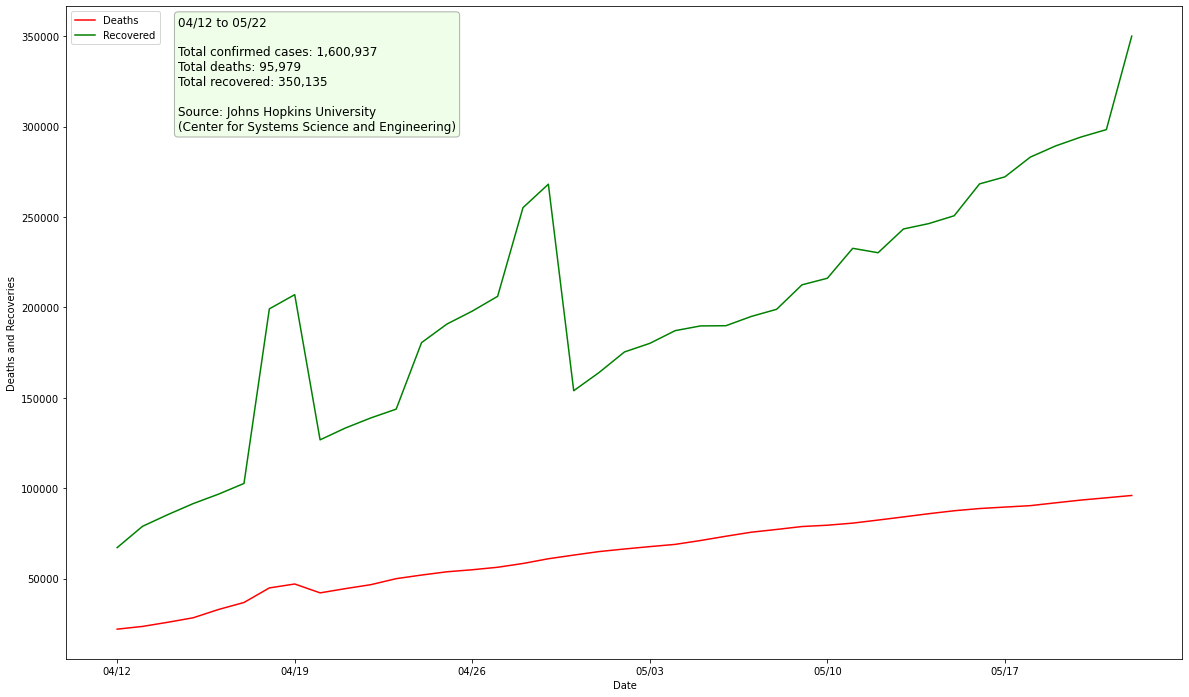

In [7]:
# Line chart plot of deaths and recoveries.

fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
#ax.plot(x_dates, total_cases, color='blue', label='Confirmed Cases')
ax.plot(x_dates, total_recovered, color='green', label='Recovered')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths and Recoveries')
ax.legend()
text = f"""{x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.1, 0.81, text)

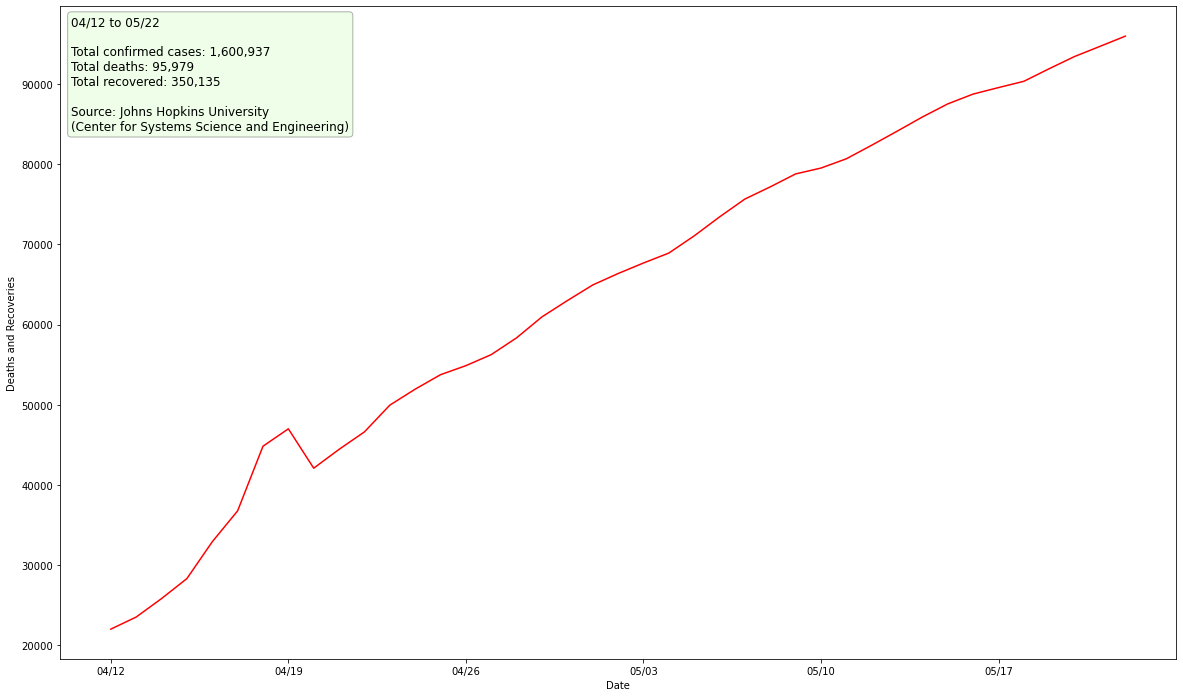

In [8]:
# Deaths only.

fig, ax = p.subplots(figsize=(20, 12))

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths and Recoveries')
text = f"""{x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.81, text)

#### Just the past week

In [9]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
print(datestr(six_days_prior, include_year=True))
print(datestr(jhu_ending_date, include_year=True))

05/16/2020
05/22/2020


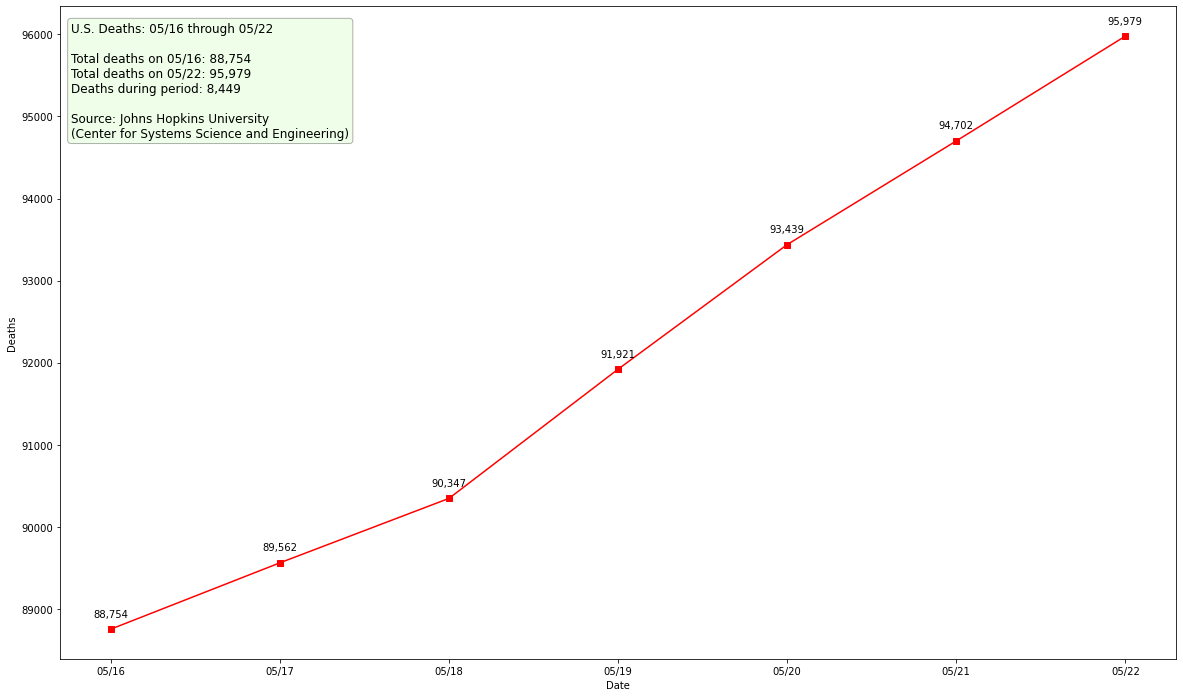

In [10]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order if d >= six_days_prior]
deaths_a_week_ago = sum([j.deaths for state, j in jhu_data[jhu_ending_date - timedelta(days=7)].items()])
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    if date < six_days_prior:
        continue
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='s')
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

# Put the actual numbers on the chart.
for x, y in zip(x_dates, total_deaths):
    label = f"{y:,}"
    # The xytext values are absolute — and kind of fiddly.
    ax.annotate(label, (x, y), ha='center', xytext=(x, y+150))

text = f"""U.S. Deaths: {x_dates[0]} through {x_dates[-1]}

Total deaths on {x_dates[0]}: {total_deaths[0]:,}
Total deaths on {x_dates[-1]}: {total_deaths[-1]:,}
Deaths during period: {(total_deaths[-1] - deaths_a_week_ago):,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.80, text)
fig.savefig(os.path.join(IMAGES_PATH, 'past-week.png'))

### Deaths vs. Confirmed Cases vs. People Tested

U.S. COVID-19: 04/12 through 05/22

Total deaths: 95,979
Total people recovered: 350,135
Total people tested: 13,398,624
Total confirmed cases: 1,600,937

Source: Johns Hopkins University
(Center for Systems Science and Engineering)


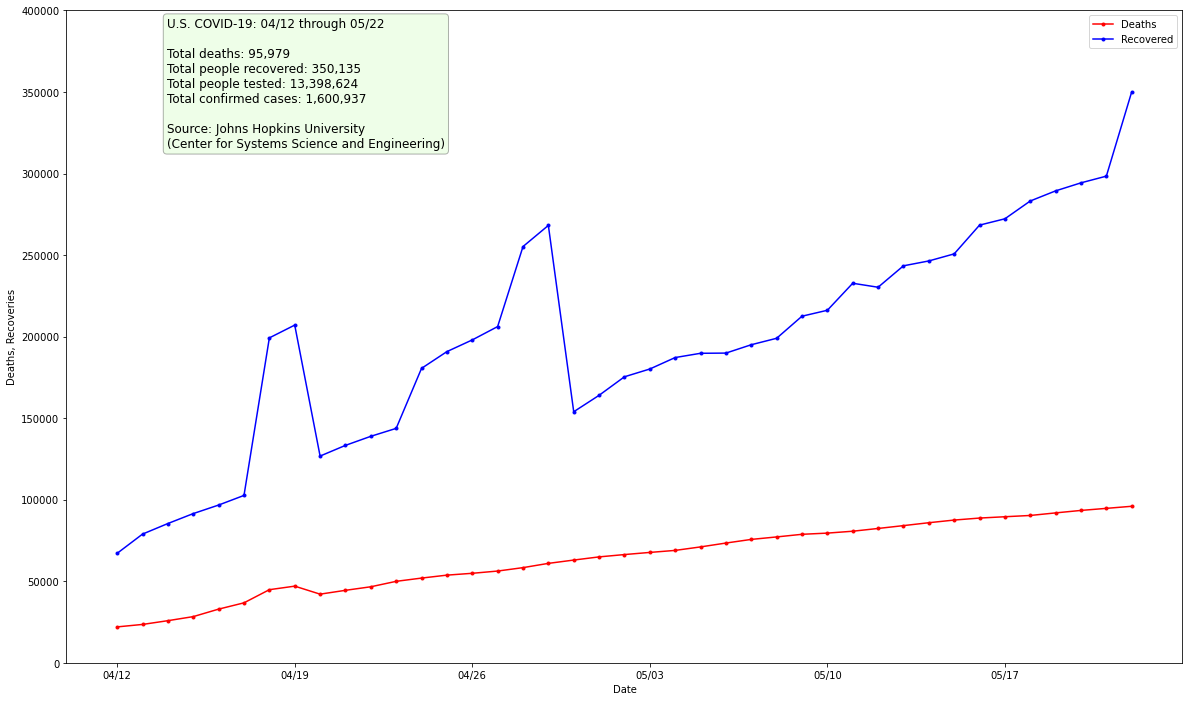

In [11]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_tested = []
total_recovered = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.confirmed for state, j in data.items()]))
    total_tested.append(sum([j.tested for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))
    
ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='.')
ax.plot(x_dates, total_recovered, color='blue', label='Recovered', marker='.')
#ax.plot(x_dates, total_tested, color='green', label='Tested', marker='.')
#ax.plot(x_dates, total_cases, color='orange', label='All Cases', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
max_number = max(total_deaths[-1], total_recovered[-1])
ymax, stride = determine_ymax_and_stride(max_number)
ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Deaths, Recoveries')

ax.legend()

text = f"""U.S. COVID-19: {x_dates[0]} through {x_dates[-1]}

Total deaths: {total_deaths[-1]:,}
Total people recovered: {total_recovered[-1]:,}
Total people tested: {total_tested[-1]:,}
Total confirmed cases: {total_cases[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.09, 0.79, text)
fig.savefig(os.path.join(IMAGES_PATH, 'deaths-recoveries.png'))
print(text)

### Mortality rates over time

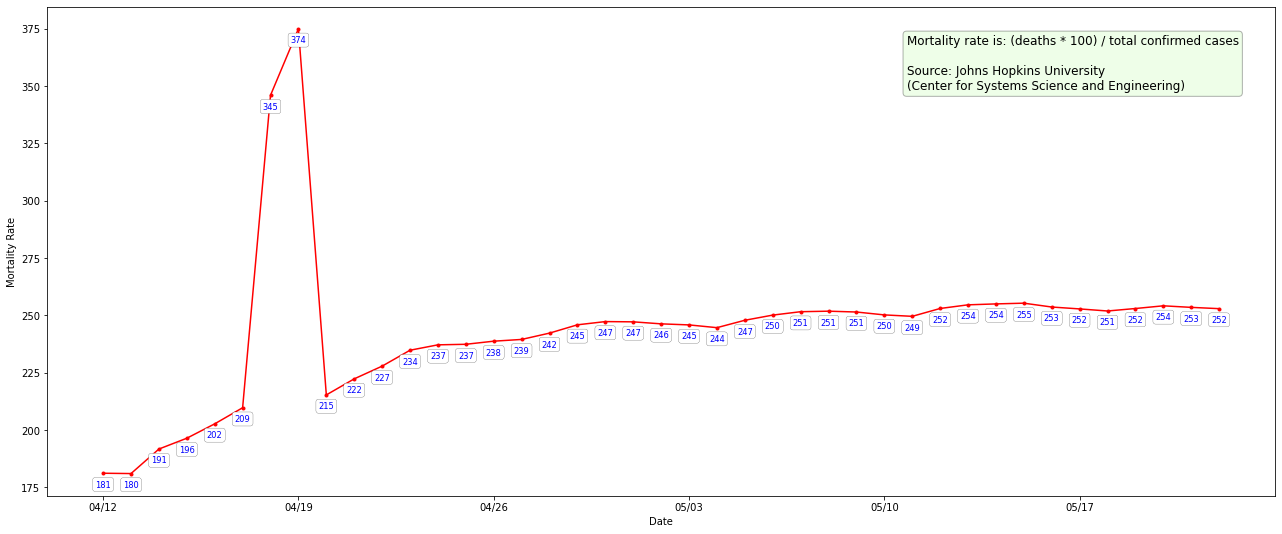

In [12]:
fig, ax = p.subplots(figsize=(22, 9))
x_dates = [datestr(d) for d in dates_in_order]
total_mortality_rate = []

for date in dates_in_order:
    data = jhu_data[date]
    total_mortality_rate.append(sum([j.mortality_rate for state, j in data.items()]))
    
ax.plot(x_dates, total_mortality_rate, color='red', label='Mortality Rate', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
#max_number = max(total_deaths[-1], total_recovered[-1])
#ymax, stride = determine_ymax_and_stride(max_number)
#ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Mortality Rate')

x_coordinates = [i for i, _ in enumerate(x_dates)]
# Put the actual numbers on the chart.
for x, y in zip(x_coordinates, total_mortality_rate):
    label = f"{int(y):,}"
    # The xytext values are absolute — and kind of fiddly.
    box_props = {
        'boxstyle': 'round',
        'facecolor': 'white',
        'linewidth': 0.2,
        'alpha': 1.0,
    }
    ax.annotate(label, (x, int(y)), ha='center', xytext=(x, y-6),
                bbox=box_props, fontsize='small', color='blue')

#ax.legend()

text = f"""Mortality rate is: (deaths * 100) / total confirmed cases

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.70, 0.83, text)
fig.savefig(os.path.join(IMAGES_PATH, 'mortality.png'))

### Individual States

In [13]:
def plot_state(state, color='red', fig=None, ax=None, image_file=None, with_confirmed=False):
    if ax is None:
        fig, ax = p.subplots(figsize=(20, 12))

    x_dates = [datestr(d) for d in dates_in_order]
    total_deaths = []
    total_cases = []
    total_recovered = []

    for date in dates_in_order:
        data = jhu_data[date][state]
        total_deaths.append(data.deaths)
        total_cases.append(data.confirmed)
        total_recovered.append(data.recovered)

    ax.plot(x_dates, total_deaths, color=color, label='Deaths')
    if with_confirmed:
        ax.plot(x_dates, total_cases, color='blue', label='Confirmed Cases')

    ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
    max_deaths = total_deaths[-1]
    if with_confirmed:
        max_y = max(total_deaths[-1], total_cases[-1])
    else:
        max_y = max_deaths
    ymax, stride = determine_ymax_and_stride(max_y)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel('Deaths, Confirmed Cases, Recoveries')
    if with_confirmed:
        ax.legend()
    final_total_recovered = total_recovered[-1]
    recovered_summary = f"{final_total_recovered:,}" if final_total_recovered > 0 else "No data on recovered cases"
    text = f"""{state}: {x_dates[0]} to {x_dates[-1]}

Total confirmed cases: {total_cases[-1]:,}
Total deaths: {max_deaths:,}
Total recovered: {recovered_summary}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
    textbox(ax, 0.01, 0.80, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
        
    return (fig, ax)

#### Pennsylvania

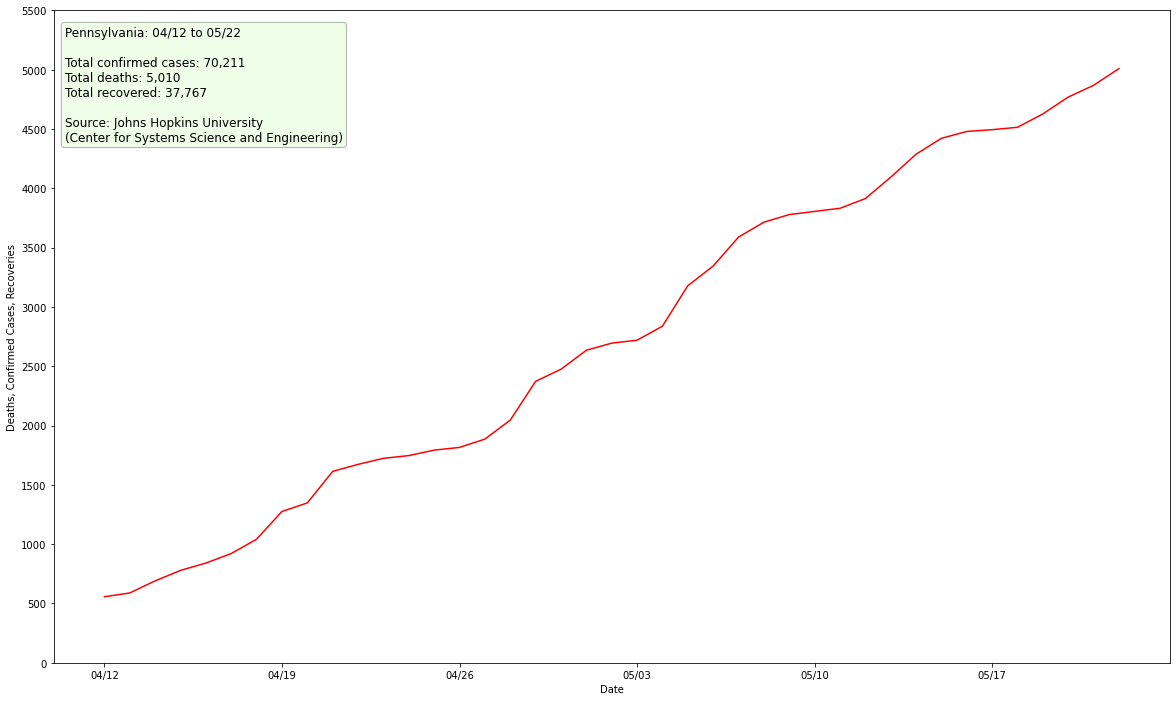

In [14]:
fig, ax = plot_state('Pennsylvania', image_file="pa.png")

#### New York

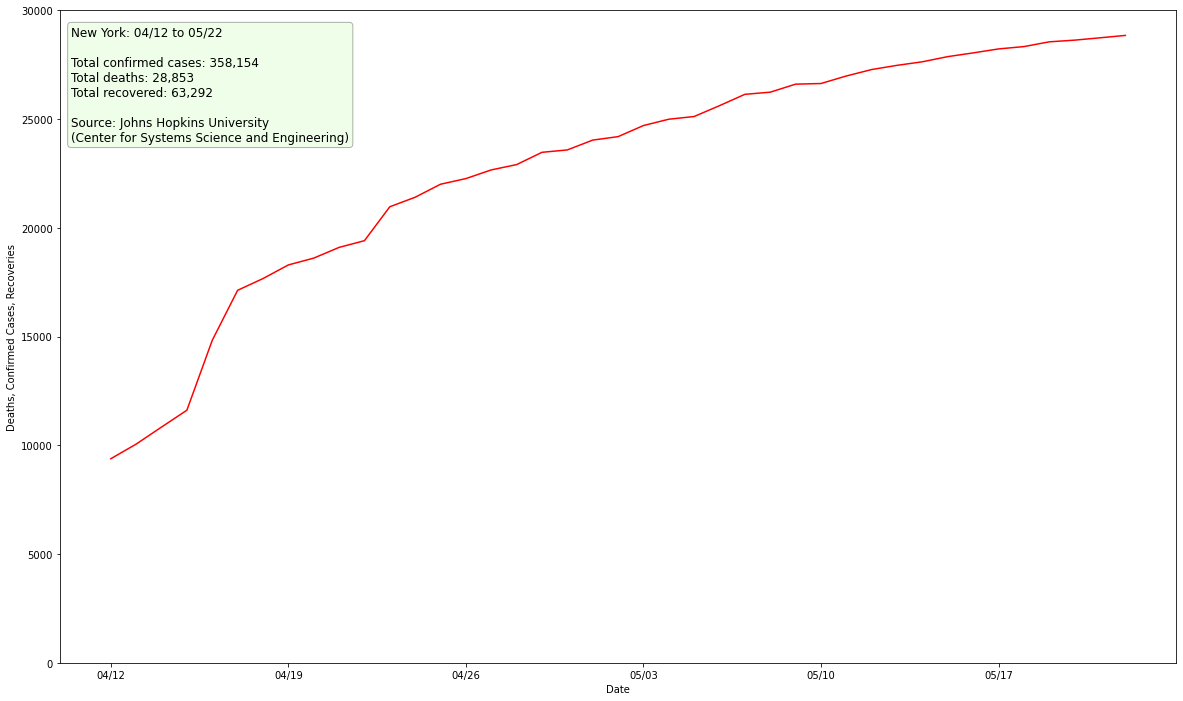

In [15]:
ax, fig = plot_state('New York', image_file="ny.png")

#### Washington

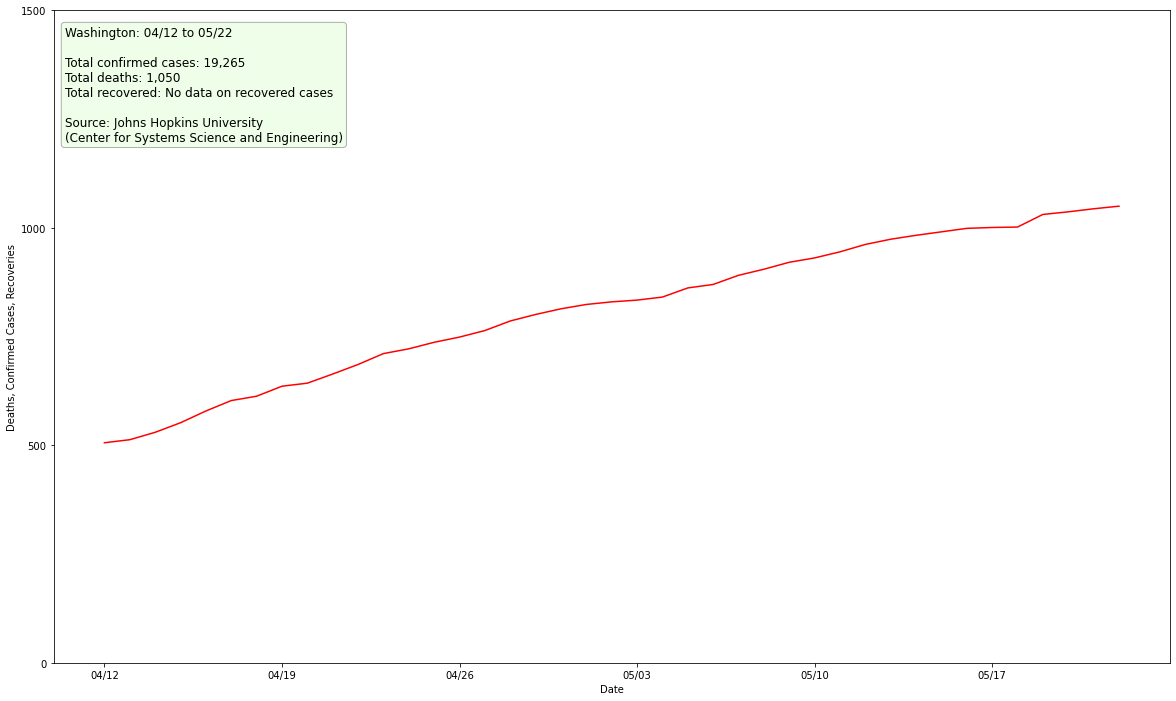

In [16]:
fig, ax = plot_state('Washington', image_file="wa.png")

#### Delaware

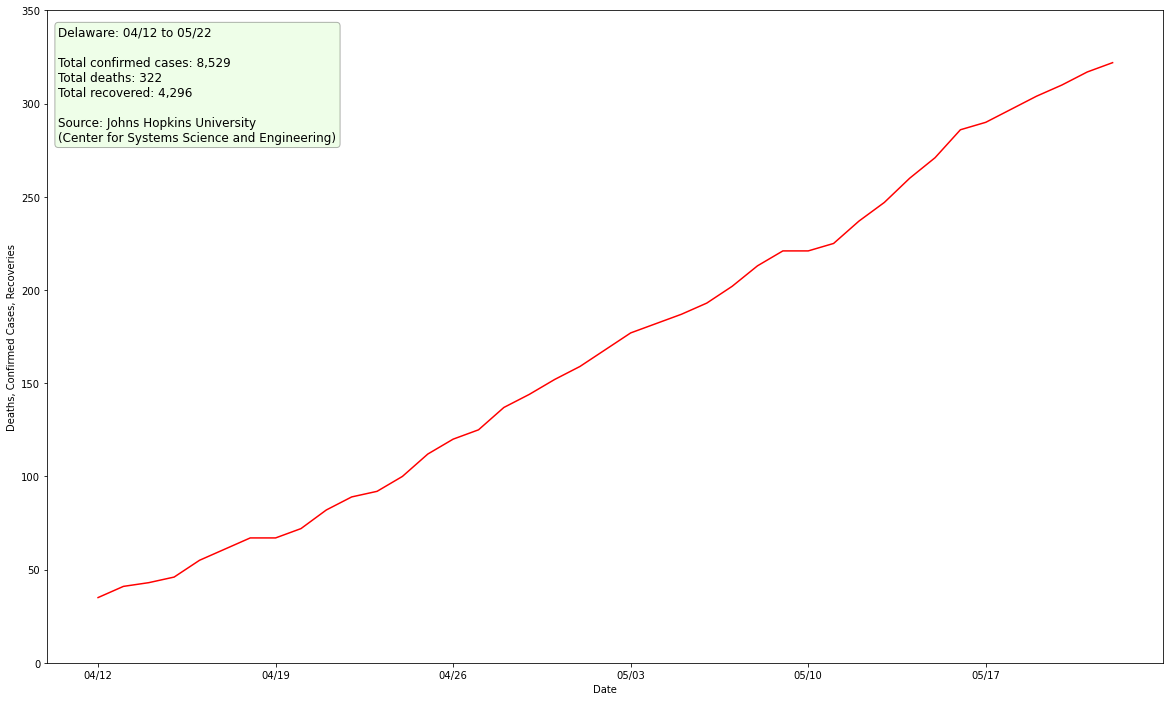

In [17]:
fig, ax = plot_state('Delaware', image_file='de.png')

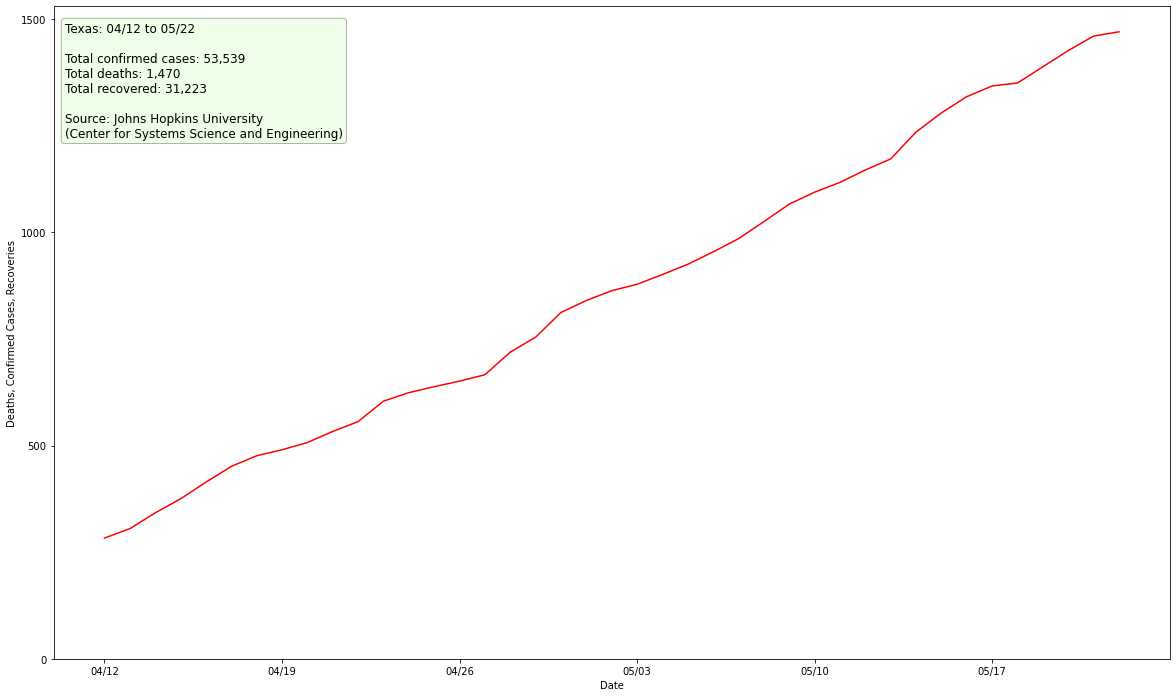

In [18]:
ax, fig = plot_state('Texas', image_file="tx.png")

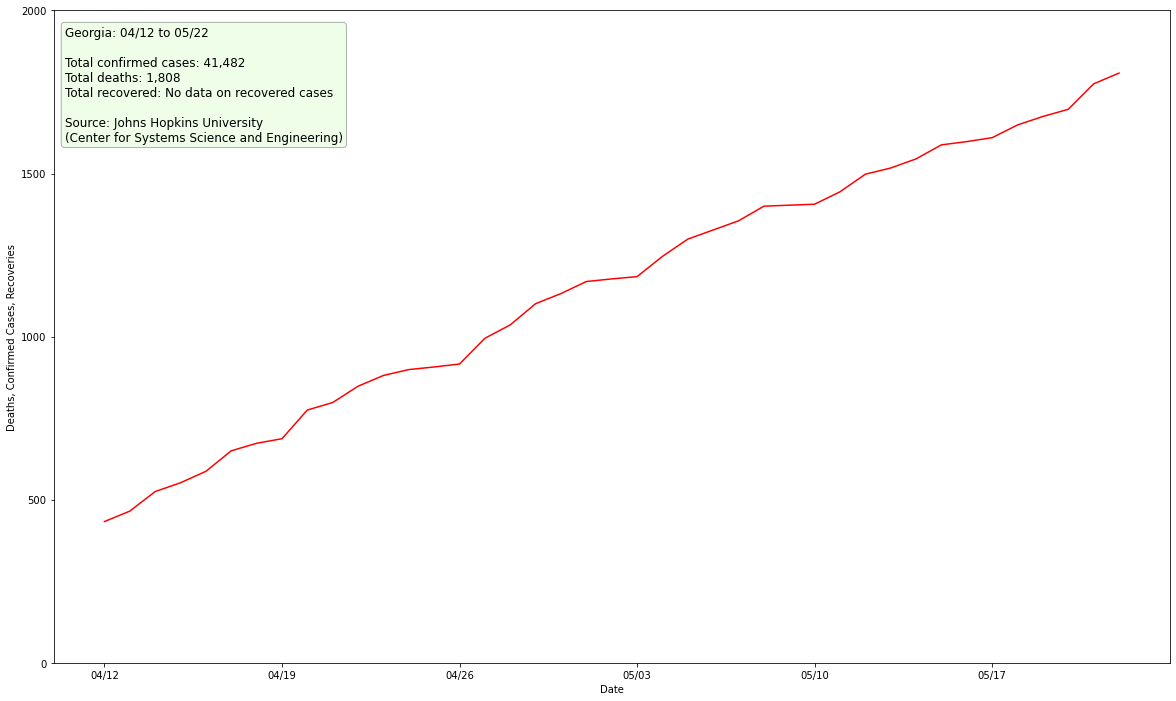

In [19]:
ax, fig = plot_state('Georgia', image_file="ga.png")

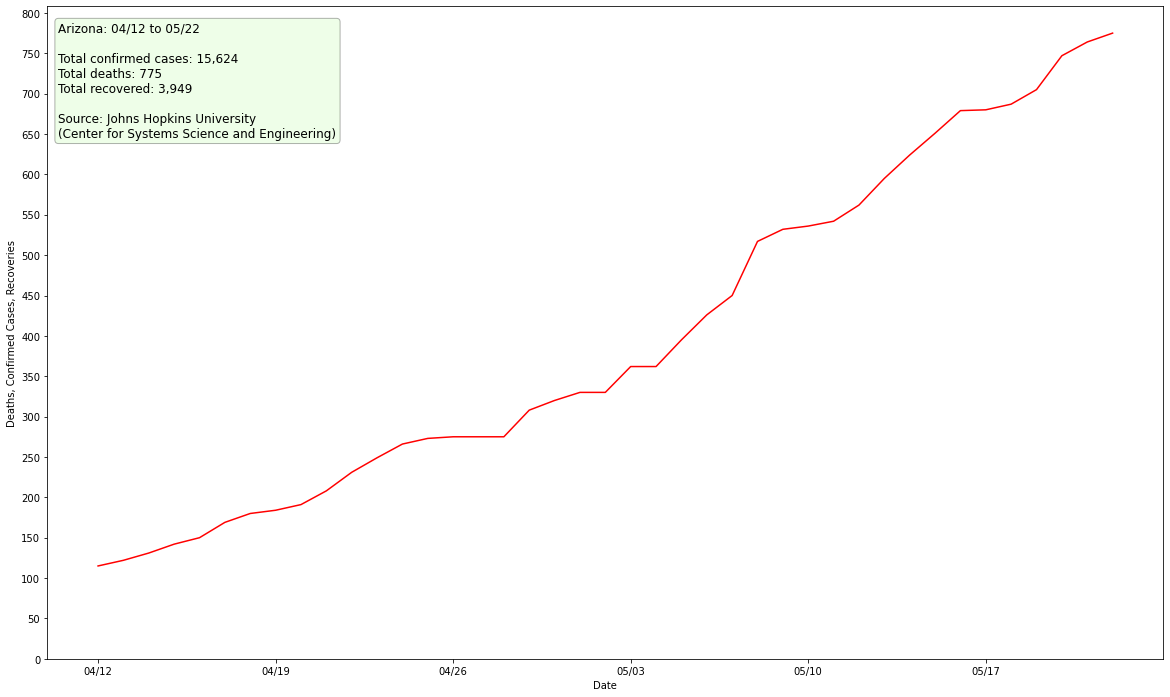

In [20]:
ax, fig = plot_state('Arizona', image_file="az.png")

### Multistate

In [21]:
def jhu_plot_states(jhu_data, states, text_x=0.12, text_y=0.69, image_file=None):
    fig, ax = p.subplots(figsize=(20, 11))

    total_deaths_by_state = dict()
    for state, (color, linestyle) in zip(states, LINE_COLORS_AND_STYLES):
        x_dates = [datestr(d) for d in dates_in_order]
        total_deaths = []
        total_cases = []
        total_recovered = []

        for date in dates_in_order:
            data = jhu_data[date][state]
            total_deaths.append(data.deaths)
            total_cases.append(data.confirmed)
            total_recovered.append(data.recovered)

        ax.plot(x_dates, total_deaths, color=color, label=state, linestyle=linestyle)
        total_deaths_by_state[state] = total_deaths[-1]

    max_total_deaths = max(total_deaths_by_state.values())
    ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
    ymax, stride = determine_ymax_and_stride(max_total_deaths)
    ax.set_yticks(range(0, ymax)[::stride])
    ax.set_xlabel('Date')
    ax.set_ylabel('Deaths, Confirmed Cases, Recoveries')
    ax.legend()

    text_lines = ["TOTAL DEATHS", ""]
    for state, count in sorted(total_deaths_by_state.items(), key=lambda v: v[1], reverse=True):
         text_lines.append(f"{state}: {count:,}")

    last_day = jhu_data[dates_in_order[-1]]
    total_deaths_in_us = sum([j.deaths for j in last_day.values()])

    text = '\n'.join(text_lines)
    textbox(ax, text_x, text_y, text)
    textbox(ax, 0.26, 0.97, f"Total US Deaths in Period: {total_deaths_in_us:,}", bg='xkcd:pale blue')
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
    return fig, ax

#### Same set of states used in CDC plot, above

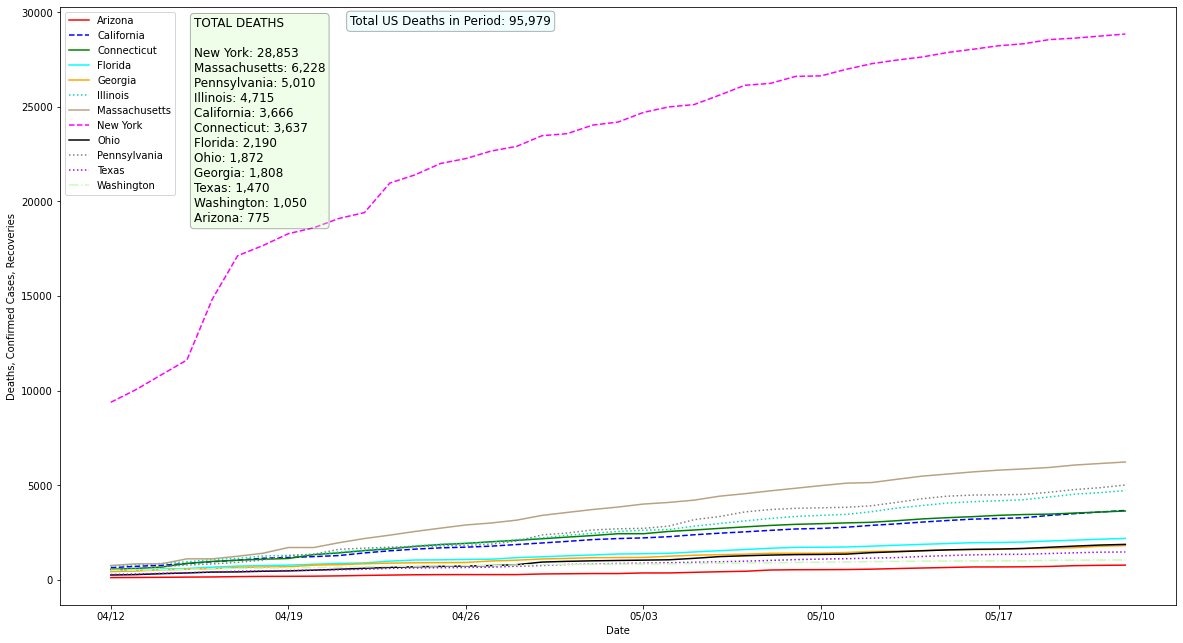

In [31]:
fig, ax = jhu_plot_states(jhu_data, STATES_TO_COMPARE, image_file='states1.png', text_y=0.640)

#### Sames states, but without New York

New York, as a hotspot, skews the graph.

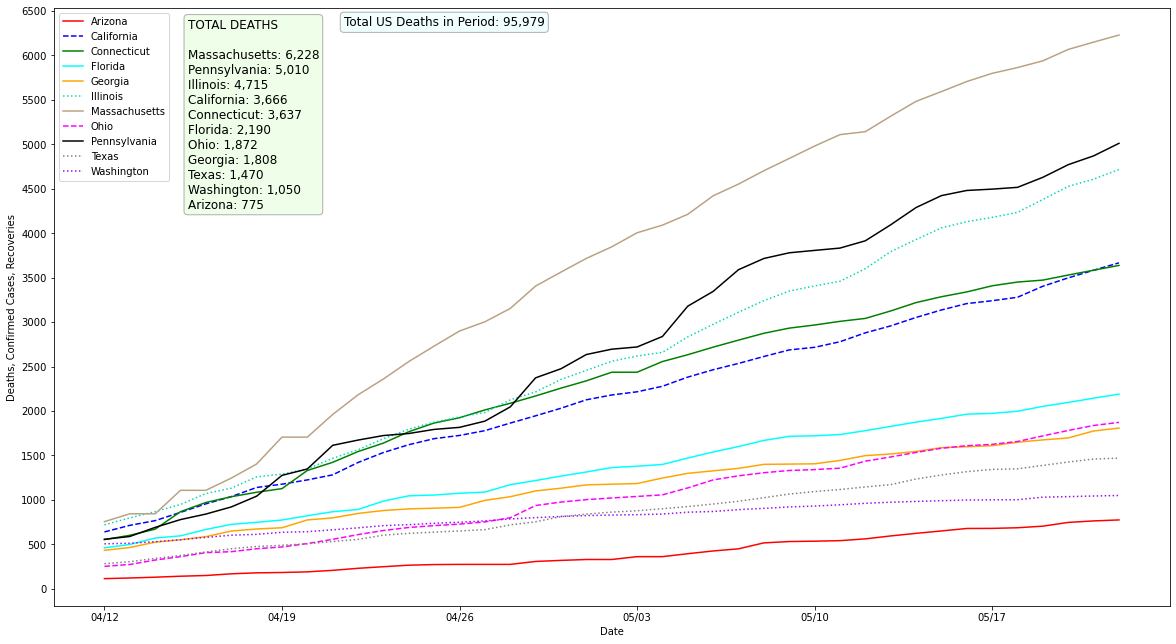

In [28]:
without_ny = sorted(list(set(STATES_TO_COMPARE) ^ set(('New York',))))
fig, ax = jhu_plot_states(jhu_data, without_ny, text_y=0.665, image_file='states2.png')